# 抓取股票

In [1]:
#https://aronhack.com/zh/retrieve-stock-historical-data-with-python-and-yahoo-finance-api/
#https://blog.techbridge.cc/2020/09/21/python-pandas-zen-tutorial/
import requests
import numpy as np
import yfinance as yf
import pandas as pd
import time
import urllib.request as request
import json
stock_list=['2603']
# 開始爬蟲
historical_data = pd.DataFrame()
for i in stock_list:    
    
    # 抓取股票資料
    stock_id = i + '.TW'
    data = yf.Ticker(stock_id)
    df = data.history(period="max")

    # 在表格中增加股票代號
    df['STOCK_ID'] = i
    
    # 將資料格式化
    stock = pd.DataFrame(df)

    # 將df與一開始的空表格合併成一張完整表格
    historical_data = pd.concat([historical_data, stock])
    
    # 記得爬蟲禮儀
    time.sleep(0.8)
historical_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,STOCK_ID
Date,,,,,,,,
2000-01-04,7.214513,7.350636,7.132840,7.350636,17447178,0.0,0.0,2603
2000-01-05,7.323411,7.350635,7.132839,7.268960,13205004,0.0,0.0,2603
2000-01-06,7.268960,7.486757,7.241736,7.459533,22311061,0.0,0.0,2603
2000-01-07,7.922350,7.976802,7.731777,7.976802,55252396,0.0,0.0,2603
2000-01-10,8.085699,8.085699,7.813453,7.895126,29083459,0.0,0.0,2603
...,...,...,...,...,...,...,...,...
2021-06-30,181.500000,197.000000,181.500000,197.000000,124635805,0.0,0.0,2603
2021-07-01,204.000000,216.000000,195.000000,213.000000,164144137,0.0,0.0,2603
2021-07-02,213.000000,219.000000,200.000000,206.500000,543116488,0.0,0.0,2603


# 建立挑選股票與時段的函式

In [2]:
#挑選股票與時段
def pick(stock_number, period_start, period_end):
    global historical_data
    a = historical_data['STOCK_ID'] == stock_number
    a = historical_data[a].loc[period_start : period_end]
    return a

# 用函式定義標的
s2603 = pick('2603', '2021-01-01', '2021-07-06')

# 安裝talib指標套件，並建立KD進出函式

In [3]:
# talib官網: http://mrjbq7.github.io/ta-lib/doc_index.html
# talib中文教學: https://medium.com/ai%E8%82%A1%E4%BB%94/%E7%94%A8-python-%E5%BF%AB%E9%80%9F%E8%A8%88%E7%AE%97-158-%E7%A8%AE%E6%8A%80%E8%A1%93%E6%8C%87%E6%A8%99-26f9579b8f3a

import talib

def KD(sXXXX):
    

# 定義KD各項數值
    sXXXX['K'],sXXXX['D']=talib.STOCH(sXXXX['High'],
                                      sXXXX['Low'],
                                      sXXXX['Close'],
                                      fastk_period=9,
                                      slowk_period=3,
                                      slowk_matype=1,
                                      slowd_period=3,
                                      slowd_matype=1)

# 每日資料加入前一天的KD值
    sXXXX['Y_K']=sXXXX['K'].shift(1)
    sXXXX['Y_D']=sXXXX['D'].shift(1)

# 定義黃金交叉
    bs=[]
    for i in range(len(sXXXX)):
        if sXXXX['K'][i]>sXXXX['D'][i] and sXXXX['Y_K'][i]<sXXXX['Y_D'][i]:
            bs.append('buy')
        else:
            bs.append('n')        


# 定義死亡交叉
    for i in range(len(sXXXX)):
        if sXXXX['K'][i]<sXXXX['D'][i] and sXXXX['Y_K'][i]>sXXXX['Y_D'][i]:
            bs[i]='sell'

# 新增買賣訊號
    sXXXX['BS']=bs
    return sXXXX

s2603=KD(s2603)    #替換成新的DataFrame

In [4]:
# 列出買賣點
s2603.loc[s2603['BS'].isin(['buy']) | s2603['BS'].isin(['sell'])]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,STOCK_ID,K,D,Y_K,Y_D,BS
Date,,,,,,,,,,,,,
2021-01-21,31.549999,33.400002,31.150000,32.099998,430337549,0.0,0.0,2603,11.030465,9.358540,5.654691,7.686615,buy
2021-01-29,33.450001,33.549999,30.850000,31.200001,268576671,0.0,0.0,2603,29.362653,33.622486,41.078234,37.882319,sell
2021-02-02,31.600000,34.299999,31.400000,34.099998,359344696,0.0,0.0,2603,41.297875,34.930775,23.504863,28.563674,buy
2021-02-24,38.599998,38.950001,36.750000,36.750000,248067213,0.0,0.0,2603,67.845286,75.324827,83.892010,82.804367,sell
2021-03-09,37.500000,38.400002,36.750000,38.400002,147907324,0.0,0.0,2603,55.514010,48.940146,39.028000,42.366283,buy
2021-03-19,41.150002,42.750000,41.099998,41.700001,275650592,0.0,0.0,2603,87.977794,88.195656,93.455575,88.413518,sell
2021-03-22,44.000000,45.849998,43.700001,45.849998,400703270,0.0,0.0,2603,93.988897,91.092276,87.977794,88.195656,buy
2021-03-23,46.900002,47.599998,42.200001,42.750000,589436761,0.0,0.0,2603,71.333073,81.212674,93.988897,91.092276,sell
2021-03-31,44.200001,46.799999,44.000000,45.500000,338539529,0.0,0.0,2603,58.202048,54.135242,48.711765,50.068435,buy


# 建立BBands函式

In [5]:
# https://chenchenhouse.com/python004/#%E7%B9%AA%E8%A3%BD%E5%B8%83%E6%9E%97%E9%80%9A%E9%81%93

def BBands(sXXXX):
    sXXXX["upper"], sXXXX["middle"], sXXXX["lower"] = talib.BBANDS(sXXXX["Close"], timeperiod=5, nbdevup=2.1, nbdevdn=2.1, matype=0)
BBands(s2603)


# mplfinance 繪圖套件

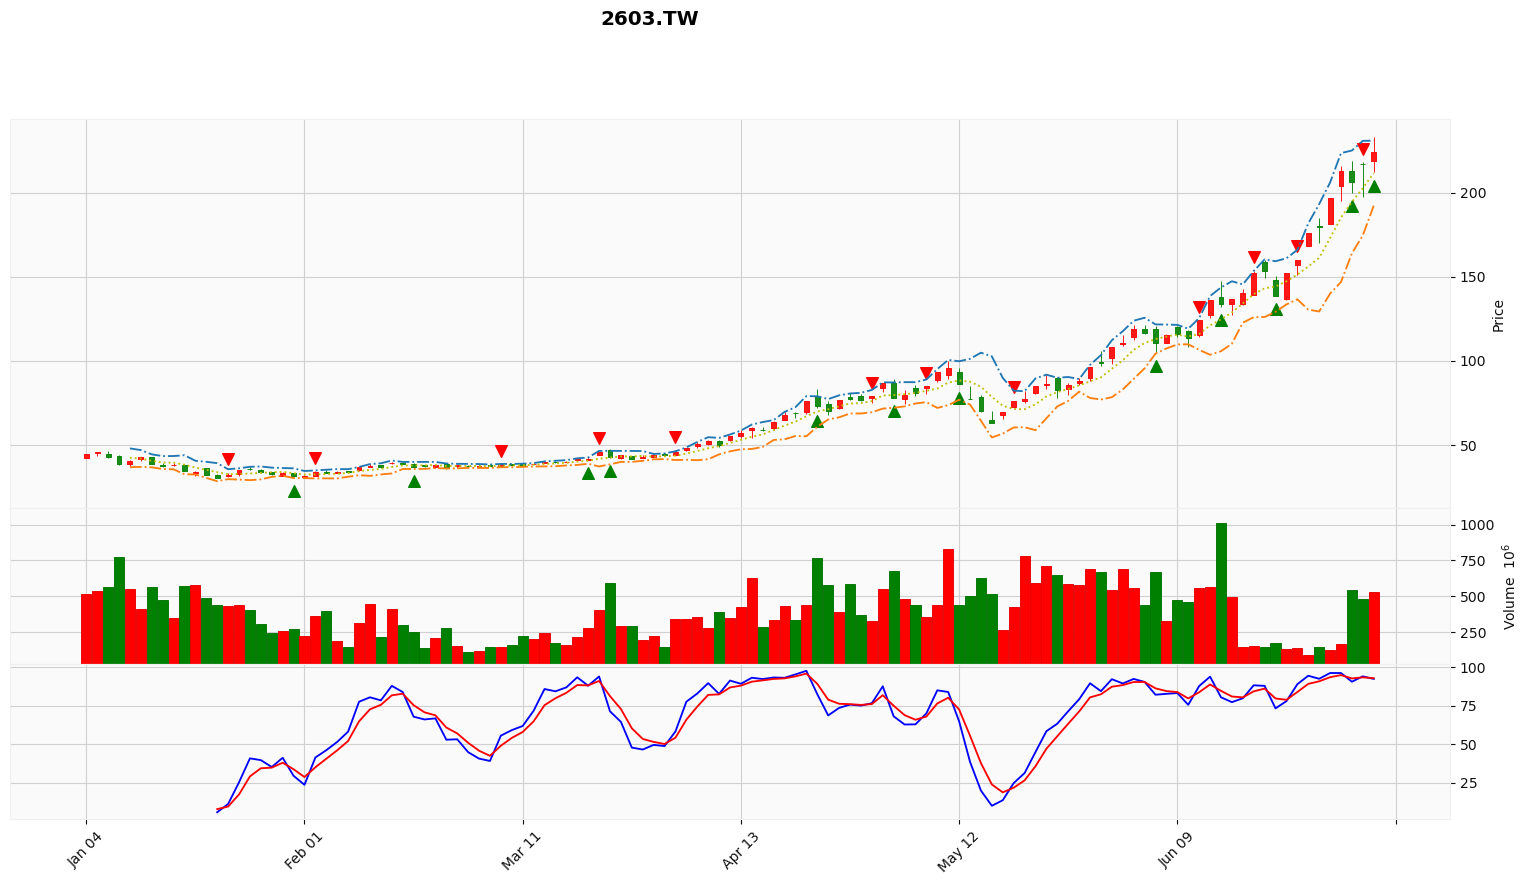

In [10]:
# mplfinance繪圖: https://waynestalk.com/python-candlesticks/#%e5%9f%ba%e6%9c%ac%e7%94%a8%e6%b3%95
import mplfinance as mpf

buy_mark = []
for i in range(len(s2603)):
    if s2603['BS'][i] == 'buy':
        buy_mark.append(s2603['High'][i]+8)
    else:
        buy_mark.append(np.nan)
s2603['Buy_mark']=buy_mark       
        
sell_mark = []
for i in range(len(s2603)):
    if s2603['BS'][i] == 'sell':
        sell_mark.append(s2603['Low'][i]-8)
    else:
        sell_mark.append(np.nan)
s2603['Sell_mark']=sell_mark

        
# 設定顏色
mc = mpf.make_marketcolors(up='r',
                           down='g',
                           edge='',
                           wick='inherit',
                           volume='inherit')

# 設定樣式
s = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)

# 加入買賣點與KD線
add_plot = [mpf.make_addplot(s2603['Buy_mark'], scatter=True, markersize=70, marker='v', color='r'),
            mpf.make_addplot(s2603['Sell_mark'], scatter=True, markersize=70, marker='^', color='g'),
            mpf.make_addplot(s2603['K'], panel=2, color='b'),
            mpf.make_addplot(s2603['D'], panel=2, color='r'),
            mpf.make_addplot(s2603[['upper','lower']],linestyle='dashdot'),
            mpf.make_addplot(s2603['middle'],linestyle='dotted',color='y')]

kwargs = dict(type='candle', volume=True, figsize=(20,10), title='2603.TW', style=s, addplot=add_plot)
mpf.plot(s2603, **kwargs)

# 建立買進賣出與報酬率函式

In [7]:
def in_out(target):
    in_out_data={}
    rate=[]
    in_date=[]
    out_date=[]
    for i in range(len(target)):
        if target['BS'][i]=='buy':               # 找出買入點
            for g in range(i+1,len(target)):     # 往後找賣出點
                if target['BS'][g]=='sell':
                    rate.append(((float(target['Close'][g])-float(target['Close'][i]))/float(target['Close'][i]))*100)   #求波段報酬率
                    in_date.append(target.index[i])
                    out_date.append(target.index[g])
                    break
    global pd
    in_out_data['in_date']=in_date
    in_out_data['out_date']=out_date
    in_out_data['return_rate(%)']=rate
    
    return pd.DataFrame(in_out_data)
                
transaction=in_out(s2603)       
transaction

,in_date,out_date,return_rate(%)
0,2021-01-21,2021-01-29,-2.803731
1,2021-02-02,2021-02-24,7.771266
2,2021-03-09,2021-03-19,8.593748
3,2021-03-22,2021-03-23,-6.761175
4,2021-03-31,2021-04-22,60.219784
5,2021-04-29,2021-05-04,-1.265823
6,2021-05-07,2021-05-12,1.294116
7,2021-05-19,2021-06-07,44.823061
8,2021-06-11,2021-06-16,7.661290
9,2021-06-21,2021-06-23,-8.881579


# 建立比較函式

In [8]:
def compair(target):
    global in_out
    transaction=in_out(target) 
    main_return=sum(transaction['return_rate(%)'])     #交易策略的總報酬率
    
    Buddha_return=((float(target['Close'][-1])-float(target['Close'][0]))/float(target['Close'][0]))*100    #抱到底的報酬率
    if main_return>Buddha_return:
        print(' return_rate is', main_return,'%, which is a Good trading straregy!', '\n', 'Buddha_return', 'is', Buddha_return, '%')
    else:
        print(' return_rate is', main_return,'% which is not we want QQ', '\n', 'Buddha_return', 'is', Buddha_return, '%')
compair(s2603)

 return_rate is 142.93926303612452 % which is not we want QQ 
 Buddha_return is 400.5586592178771 %
